In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
# nltk
import nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
tqdm.pandas()

In [2]:
category_ids = {'negative': 0, 'positive': 1}

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = set(['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves'] + [w for w in stopwords.words('english')])

HASHTAG_SPEC = 'HASHTAG'
USER_SPEC = 'USER'
URL_SPEC = 'URL'
EMOJI_SPEC = 'EMOJI'

urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
tagPattern        = '#[^\s]+'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

wordLemm = WordNetLemmatizer()

In [3]:
def preprocess_text(tweet):
    tweet = tweet.lower()    
        # Replace all URls with 'URL'
    tweet = re.sub(urlPattern, f' {URL_SPEC} ' , tweet)
        # Replace all emojis.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, f" {EMOJI_SPEC}" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern, f' {USER_SPEC} ' , tweet)   
    tweet = re.sub(tagPattern, f' {HASHTAG_SPEC} ' , tweet)
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " " , tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    tweet = ' '.join([wordLemm.lemmatize(word) for word in tweet.split() if len(word) > 1 and word not in stopwordlist])
    return tweet

In [4]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [5]:
df_train['text'] = df_train['text'].progress_apply(preprocess_text)
df_train['target'] = df_train['target'].apply(lambda x : category_ids[x])

df_test['text'] = df_test['text'].progress_apply(preprocess_text)
df_test['target'] = df_test['target'].apply(lambda x : category_ids[x])

100%|██████████| 10000/10000 [00:00<00:00, 11577.79it/s]


In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(df_train['text'])
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

In [7]:
X_train = vectoriser.transform(df_train['text'])
X_test  = vectoriser.transform(df_test['text'])
print(f'Data Transformed.')

Data Transformed.


In [8]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(df_test['target'], y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(df_test['target'], y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5273
           1       0.74      0.71      0.73      4727

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



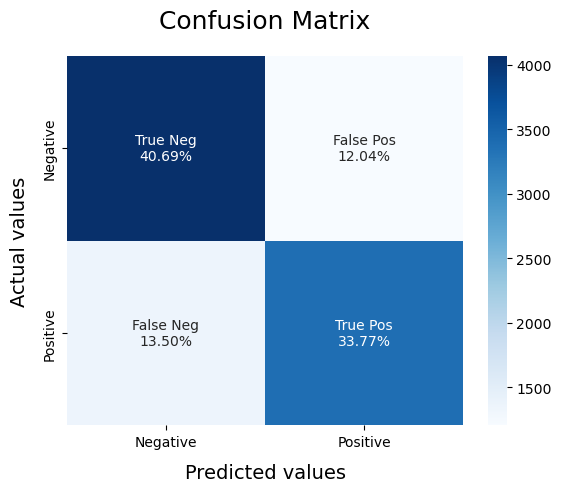

In [9]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, df_train['target'])
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      5273
           1       0.72      0.74      0.73      4727

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



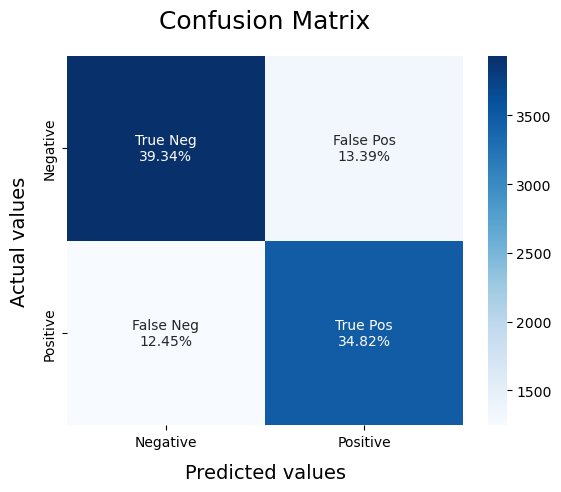

In [10]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, df_train['target'])
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      5273
           1       0.74      0.75      0.75      4727

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



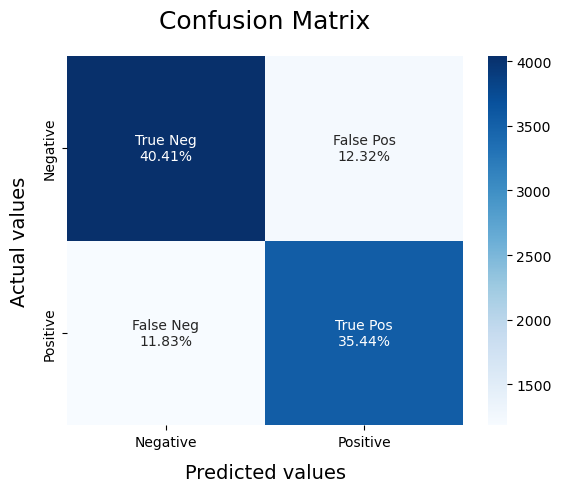

In [11]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, df_train['target'])
model_Evaluate(LRmodel)

In [12]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('SVCmodel.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

In [13]:
assert False

AssertionError: 

In [ ]:
proba = np.max(BNBmodel.predict_proba(X_train), axis=1)

In [ ]:
proba

array([0.81160196, 0.75375238, 0.99821329, ..., 0.94349294, 0.98221175,
       0.93032654])

In [ ]:
df_train_1 = pd.read_csv('data/train.csv')
df_train_1['pred'] = proba
df_train_1 = df_train_1[df_train_1['pred'] > 0.99]
df_train_1

,text,target,pred
2,The bruise on my foot is pissing me off haha. ...,negative,0.998213
4,Our love is like a song u can't forget it (8)!...,positive,0.999693
5,"@_annee sadly, no i went on ticketek one day ...",negative,0.999933
12,"gotta go get my mail from the post office, in ...",negative,0.998183
14,I miss my dad Lost him in 2000. He was my bes...,negative,0.999948
...,...,...,...
597735,Might Hit Up Studio 72 Tonight! If Not...Im Dr...,positive,0.997178
597736,@ladybug8320 excellent - no headache is very i...,negative,0.997519
597742,I'm at work right now workin for that paycheck...,negative,0.999728
597748,@SofiAlesia ...get more tan.I'm workin on it! ...,positive,0.999199
